In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()


In [3]:
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

In [4]:
file = 'datasets/housing/housing.csv'
df = pd.read_csv(file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000224E2078A58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000224E4514710>]], dtype=object)

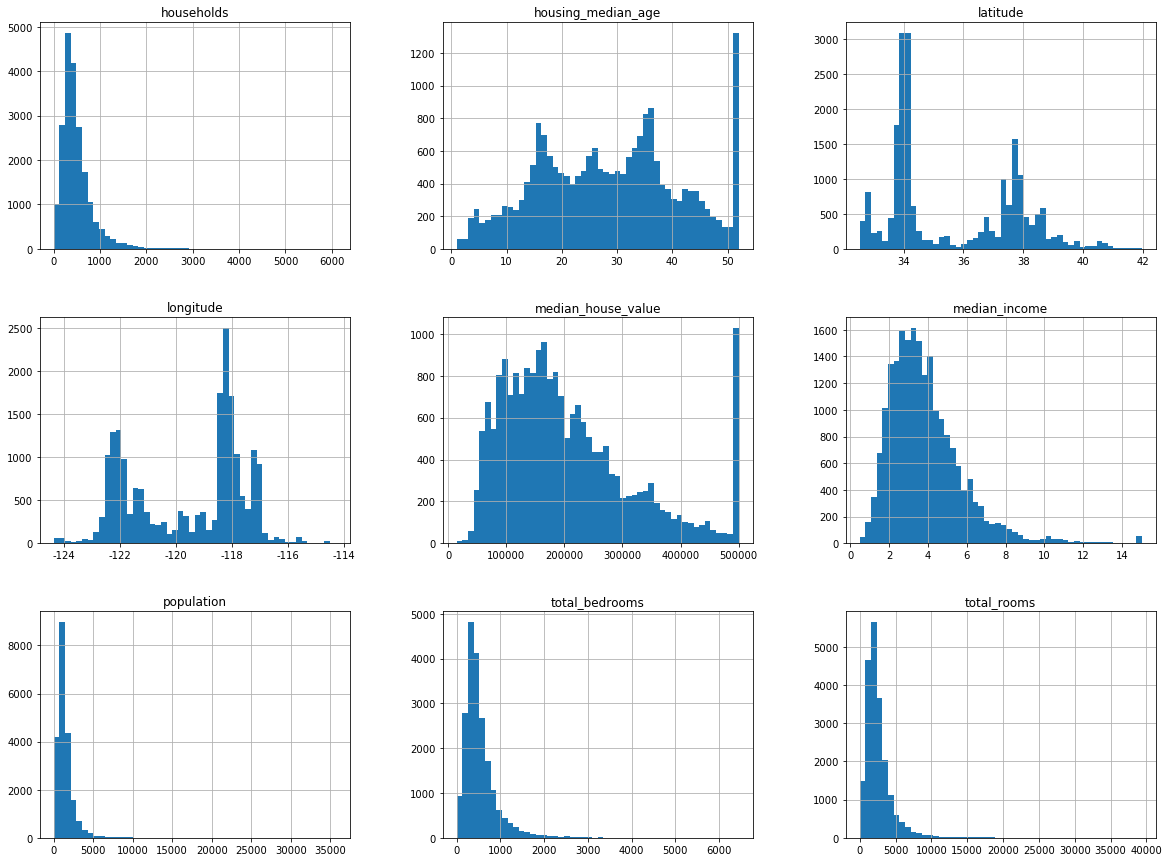

In [5]:
df.head()
df.info()
df.describe()
df.hist(bins=50, figsize=(20,15)) #bins 柱子的数量

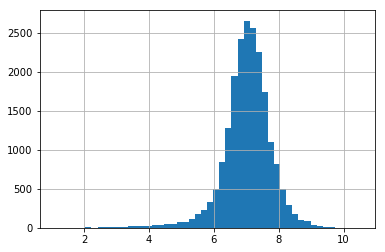

In [6]:
import numpy as np
np.log(df.population).hist(bins=50)

In [7]:
df['income_cat'] = np.ceil(df['median_income']/1.5)
df['income_cat'].where(df['income_cat'] < 5 , 5.0, inplace=True)
#DataFrame.where()
#Return an object of same shape as self and whose corresponding entries are from self where cond is True and otherwise are from other.

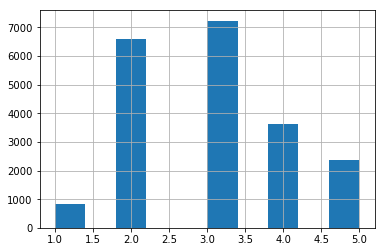

In [8]:
df.income_cat.hist()

In [9]:
df.income_cat.value_counts()/len(df)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

### Create a Test Set
#### 基于分类的分层抽样，保证样本分割后各分类的比例不变
2018年1月10日 21:54:33

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)


In [11]:
train_set.income_cat.value_counts()/len(train_set)

3.0    0.348595
2.0    0.317466
4.0    0.178537
5.0    0.115673
1.0    0.039729
Name: income_cat, dtype: float64

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2)

train_idx, test_idx = [idx for idx in split.split(df, df.income_cat)][0]

strat_train_set = df.loc[train_idx]
strat_test_set = df.loc[test_idx]

In [13]:
df.income_cat.value_counts() / len(df)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [50]:

strat_train_set.income_cat.value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

### Discover and Visualize the Data to Gain Insights

In [14]:
housing = strat_train_set.copy()

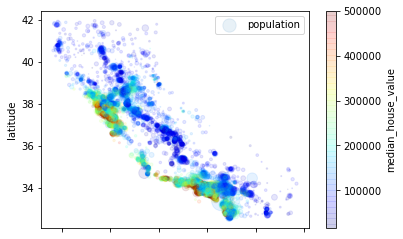

In [28]:
housing.plot(kind = 'scatter' , x='longitude', y='latitude', 
             alpha=0.1,#alpha 透明度
             s=housing['population']/100,
             label='population',
             c='median_house_value',
             cmap=plt.get_cmap('jet'),
             colorbar=True
            ) 
plt.legend()

#### 标准相关系数 or Pearson相关系数
#### only measures linear correlations

In [33]:
corr_matrix = housing.corr() #b
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
income_cat            0.642274
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000224EAD40C88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000224EB1317F0>]], dtype=object)

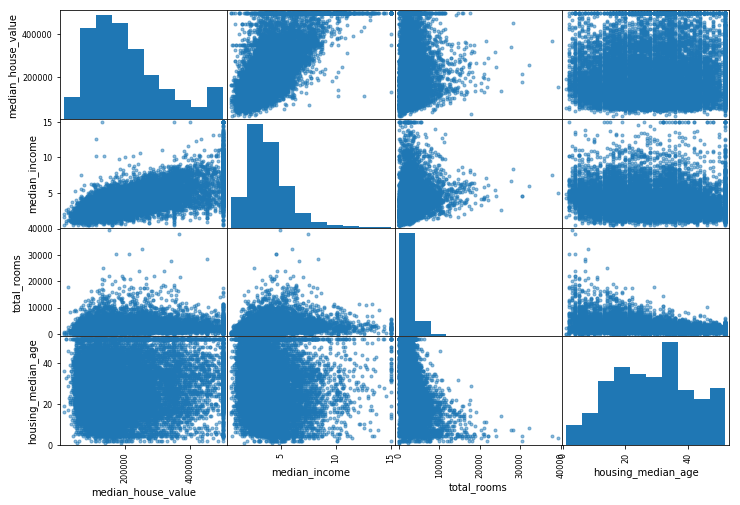

In [35]:
from pandas.tools.plotting import scatter_matrix
#housing.columns
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))

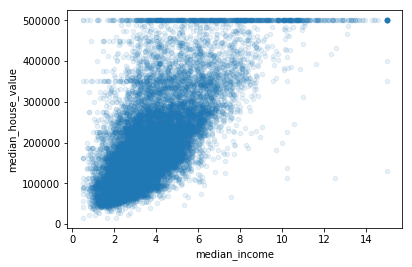

In [36]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

#### Attribute Combinations

In [39]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

corr_matrix = housing.corr() #b
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
income_cat                  0.642274
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

### Prepare Date

In [40]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set.median_house_value.copy()

#### 空值处理，插入中值

In [47]:
from sklearn.preprocessing import Imputer
housing.info()
housing.columns
housing_num = housing.drop('ocean_proximity', axis=1)
X = Imputer(strategy='median').fit_transform(housing_num)
housing_tr = pd.DataFrame(X, columns = housing_num.columns)

#2018年1月11日 22:20:03

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
income_cat            16512 non-null float64
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


#### 文本标签数据处理

In [98]:
#转为整数标签
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat_encoded = encoder.fit_transform(housing.ocean_proximity)

encoder.classes_
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3], dtype=int64)

In [97]:
#转为one-hot编码
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder() 
#Encode categorical integer features using a one-hot aka one-of-K scheme.  
#onehot 只能用于编码分类的整数，所以要先用LabelEncoder编码

#housing_cat_1hot = encoder.fit_transform(np.array([housing_cat_encoded]).T)
housing_cat_1hot = encoder.fit_transform( housing_cat_encoded.reshape(-1,1))
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [100]:
# 一步将文本分类转为one-hot编码
# LabelBinarizer
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer(sparse_output=True)

housing_cat_1hot = encoder.fit_transform(housing.ocean_proximity)
housing_cat_1hot.toarray()

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,3.006541
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,1.054602
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,1.000000
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,2.000000
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,3.000000
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,4.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,5.000000


#### Feature Scaling

In [109]:
df.describe()

from sklearn.preprocessing import MinMaxScaler, StandardScaler


scaler = StandardScaler()
housing_num_scal = scaler.fit_transform(housing_tr)

In [115]:
#标准化后均值为0，标准差为1
pd.DataFrame(housing_num_scal).describe()


,0,1,2,3,4,5,6,7,8
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04
mean,-4.272678e-15,2.275755e-15,-2.700521e-16,8.606884e-17,1.181562e-16,-4.347735e-17,9.614940e-18,-2.225960e-16,8.094812e-16
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-2.384937e+00,-1.449760e+00,-2.199168e+00,-1.223689e+00,-1.294944e+00,-1.269921e+00,-1.317668e+00,-1.772116e+00,-1.902710e+00
25%,-1.111083e+00,-7.949406e-01,-8.472092e-01,-5.516890e-01,-5.793145e-01,-5.698825e-01,-5.803963e-01,-6.870806e-01,-9.544560e-01
50%,5.324379e-01,-6.452675e-01,2.758786e-02,-2.353301e-01,-2.458409e-01,-2.292746e-01,-2.370459e-01,-1.756999e-01,-6.202241e-03
75%,7.822131e-01,9.730728e-01,6.638039e-01,2.423650e-01,2.604547e-01,2.684162e-01,2.793106e-01,4.561338e-01,9.420515e-01
max,2.630550e+00,2.951564e+00,1.856709e+00,1.716114e+01,1.381603e+01,3.071047e+01,1.293803e+01,5.839969e+00,1.890305e+00


#### Pipelines

In [118]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [119]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.42069842,
        -0.61493744, -0.95445595],
       [-1.17602483,  0.6596948 , -1.1653172 , ..., -1.02222705,
         1.33645936,  1.89030518],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.0933178 ,
        -0.5320456 , -0.95445595],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.71315642,
        -0.3167053 , -0.00620224],
       [ 0.78221312, -0.85106801,  0.18664186, ..., -0.37545069,
         0.09812139, -0.00620224],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.3777909 ,
        -0.15779865, -0.00620224]])

In [126]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [130]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num) # ? housing_num.columns.values
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizer()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)
print(housing_prepared.shape)
housing_prepared




(16512, 17)


array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

### Select and Train a Model

In [134]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [136]:
#挑样本查看预测效果
some_data = housing.iloc[:5]
some_labels = housing_labels[:5]
some_data_prepared = full_pipeline.transform(some_data)

some_data_pre = lin_reg.predict(some_data_prepared)

print(some_labels.values)
print(some_data_pre)

[ 286600.  340600.  196900.   46300.  254500.]
[ 203682.37379543  326371.39370781  204218.64588245   58685.4770482
  194213.06443039]


In [144]:
#评价 根均方差 RMSE
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
np.sqrt(lin_mse)

68376.642954599374

In [155]:
#使用决策树回归

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
np.sqrt(tree_mse)

0.0

In [158]:
from sklearn.ensemble import RandomForestRegressor
for_reg = RandomForestRegressor()
for_reg.fit(housing_prepared, housing_labels)
housing_predictions = for_reg.predict(housing_prepared)
for_mse = mean_squared_error(housing_labels, housing_predictions)
np.sqrt(for_mse)

21970.340296645889

In [160]:
from sklearn.model_selection import cross_val_score


def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation', scores.std())

for i,reg in enumerate([tree_reg, lin_reg, for_reg]):
    print(i)
    scores = cross_val_score(reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
    rmse_scores = np.sqrt(-scores).round()
    display_scores(rmse_scores)

0
Scores: [ 69569.  65994.  72102.  69411.  70940.  74739.  71455.  71578.  77489.
  70318.]
Mean: 71359.5
Standard deviation 2943.66768675
1
Scores: [ 66878.  66608.  70576.  74180.  67683.  71103.  64783.  67711.  71080.
  67688.]
Mean: 68829.0
Standard deviation 2662.66344099
2
Scores: [ 53352.  50066.  52718.  55322.  51809.  55718.  51963.  50515.  55104.
  52228.]
Mean: 52879.5
Standard deviation 1874.50432115


In [162]:
#模型的持久化
from sklearn.externals import joblib

joblib.dump(lin_reg, 'lin_reg.pkl')
joblib.dump(tree_reg, 'tree_reg.pkl')
joblib.dump(for_reg, 'for_reg.pkl')

['for_reg.pkl']

### Fine-Tune   (2018年1月12日 15:15:33)